### Instituto Tecnologico de Costa Rica (ITCR)
### Sede Interuniversitaria de Alajuela
### Escuela de Computacion
### Curso: Inteligencia Artificial
### Estudiantes: 

 - Brandon Ledezma Fernández - 2018185574
 - Walter Morales Vásquez - 2018212846

### Profesora:
 
 - Maria Auxiliadora Mora


# Tarea Programada Número 4
---
#### Introducción:
En este trabajo práctico se aplicarán conceptos básicos de aprendizaje automático
utilizando redes neuronales recurrentes para resolver problemas que involucran el
procesamiento de lenguaje natural.

El o los estudiantes deberán realizar dos ejercicios. El primero consiste en implementar
una red neuronal recurrente aplicada a un problema de clasificación de textos de opinión
sobre prendas de vestir de mujer. El segundo ejercicio consiste en reconocer nombres de
entidades en textos (NER, Named-Entity Recognition)

El objetivo del trabajo es poner en práctica las habilidades de investigación y el
conocimiento adquirido durante el curso sobre redes neuronales por medio de
ejercicios prácticos que permitan al estudiante experimentar con el aprendizaje profundo. 

In [2]:
# Bibliotecas
# ==============================================================================
import pandas as pd
import numpy as np
import random
from string import punctuation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import sklearn_crfsuite
from sklearn_crfsuite import metrics

from ner_evaluation.ner_eval import Evaluator
from ner_evaluation.ner_eval import collect_named_entities
from ner_evaluation.ner_eval import compute_metrics
from ner_evaluation.ner_eval import compute_precision_recall_wrapper

import seaborn as sn
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

from copy import deepcopy
import math

## A. Clasificación   de   textos   con   redes   neuronales   recurrentes  LSTM utilizando Pytorch.

Se desea que, dado un comentario de revisión de una prenda de vestir, predecir la calificación dada por el comprador. La calificación toma valores enteros entre 1 y 5, donde 1 corresponde a la peor calificación y 5 a la mejor.

Datos: Utilice los datos de evaluación de prendas de vestir de mujer disponibles en Kaggle (nicapotato, 2018) para:

1. Cargue y prepare los datos para ser introducidos a la red LSTM.

In [3]:
# Se carga el archivo con los datos solicitados (defaultofcredit.csv) y se define
# a la columna "default_payment_next_month" como la objetivo.
calificaciones = pd.read_csv('./data/Womens Clothing E-Commerce Reviews.csv', delimiter=',')#, nrows=nRowsRead)
calificaciones.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
calificaciones.describe()

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


In [5]:
# Diccionario con distintas contracciones del idioma ingles que 
# seran remplazadas por las palabras que conforman dicha contracción.
contracciones = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how does",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    " u ": " you ",
    " ur ": " your ",
    " n ": " and "}

# Función utilizada para tranformar las contracciones del ingles
# se recorren los comentarios o oraciones en busca de contracciones 
# que se encuentren en el diccionario para ser reemplazadas por las
# palabras que forman la contracción.
#  oracion: String
#  return: String sin contracciones
def contraccion_a_expresion(oracion):
    if type(oracion) is str:
        oracion = oracion.replace('\\', '')
        for llave in contracciones:
            valor = contracciones[llave]
            oracion = oracion.replace(llave, valor)
        return oracion
    else:
        return oracion
calificaciones['Review Text'] = calificaciones['Review Text'].apply(lambda x: contraccion_a_expresion(x))

In [6]:
# Se eliminan las columnas que contienen ya sea comentarios o calificaciones vacias
# se hace uso de la función notnull() de Pandas
calificaciones = calificaciones[calificaciones["Review Text"].notnull()]
calificaciones = calificaciones[calificaciones["Rating"].notnull()]


# Función utilizada para limpiar los datos, se utiliza los valores de punctuation,
# presentes en la biblioteca string de Python. Se transforman los caracteres a minuscula
# y se verifica que existan signos de puntuacion que eliminar
#  texto: string que puede contener caracteres
#  return: string sin signos de puntuación.
def preprocesar_texto(texto):
    texto = texto.lower()
    texto = "".join([char if char not in punctuation else " " for char in texto])
    return texto

# Se define los datos de X, que son los comentarios realizados
X = calificaciones['Review Text']
# Se transforman en datos de Python
X = X.tolist()
print(f"Valores iniciales de X: {X[:5]}")

Valores iniciales de X: ['Absolutely wonderful - silky and sexy and comfortable', 'Love this dress!  it is sooo pretty.  i happened to find it in a store, and i am glad i did bc i never would have ordered it online bc it is petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.', 'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c', 'I love, love, love this jumpsuit. it is fun, flirty, and fabulous! every time i wear it, i get nothing

In [7]:
# Se iteran los datos de X para eliminar los signos de puntuación del conjunto de datos.
for i in range(len(X)):
    X[i] = preprocesar_texto(X[i])
print(f"Valores de X sin signos de puntiación: {X[:5]}")

Valores de X sin signos de puntiación: ['absolutely wonderful   silky and sexy and comfortable', 'love this dress   it is sooo pretty   i happened to find it in a store  and i am glad i did bc i never would have ordered it online bc it is petite   i bought a petite and am 5 8    i love the length on me  hits just a little below the knee   would definitely be a true midi on someone who is truly petite ', 'i had such high hopes for this dress and really wanted it to work for me  i initially ordered the petite small  my usual size  but i found this to be outrageously small  so small in fact that i could not zip it up  i reordered it in petite medium  which was just ok  overall  the top half was comfortable and fit nicely  but the bottom half had a very tight under layer and several somewhat cheap  net  over layers  imo  a major design flaw was the net over layer sewn directly into the zipper   it c', 'i love  love  love this jumpsuit  it is fun  flirty  and fabulous  every time i wear it 

In [8]:
# Se dividen los comentarios a listas de palabras(strings), para esto se iteran
# los datos y se utiliza la función split de Python.
X = [comentario.split() for comentario in X]
print(f"Valores de X divididos: {X[:5]}")

Valores de X divididos: [['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable'], ['love', 'this', 'dress', 'it', 'is', 'sooo', 'pretty', 'i', 'happened', 'to', 'find', 'it', 'in', 'a', 'store', 'and', 'i', 'am', 'glad', 'i', 'did', 'bc', 'i', 'never', 'would', 'have', 'ordered', 'it', 'online', 'bc', 'it', 'is', 'petite', 'i', 'bought', 'a', 'petite', 'and', 'am', '5', '8', 'i', 'love', 'the', 'length', 'on', 'me', 'hits', 'just', 'a', 'little', 'below', 'the', 'knee', 'would', 'definitely', 'be', 'a', 'true', 'midi', 'on', 'someone', 'who', 'is', 'truly', 'petite'], ['i', 'had', 'such', 'high', 'hopes', 'for', 'this', 'dress', 'and', 'really', 'wanted', 'it', 'to', 'work', 'for', 'me', 'i', 'initially', 'ordered', 'the', 'petite', 'small', 'my', 'usual', 'size', 'but', 'i', 'found', 'this', 'to', 'be', 'outrageously', 'small', 'so', 'small', 'in', 'fact', 'that', 'i', 'could', 'not', 'zip', 'it', 'up', 'i', 'reordered', 'it', 'in', 'petite', 'medium', 'which', 'was'

In [9]:
# Se asigna como valores de y los datos de la columna de valor de calificación
y = calificaciones['Rating']
print("Porcentaje de calificaciones ")
largo_y = len(y.tolist())
print(f"1, {y.tolist().count(1)/largo_y*100}%")
print(f"2, {y.tolist().count(2)/largo_y*100}%")
print(f"3, {y.tolist().count(3)/largo_y*100}%")
print(f"4, {y.tolist().count(4)/largo_y*100}%")
print(f"5, {y.tolist().count(5)/largo_y*100}%")

# Se genera un diccionario con las palabran localizadas en los datos al 
# cual se le asigna un indice numerico como llave y la palabra como valor
palabras_a_indice = {"":0}
# se iteran los comentarios
for comentario in X:
    for palabra in comentario: # luego las palabras
        if palabra not in palabras_a_indice: # si la palabra no se ha registrado se agrega
            palabras_a_indice[palabra] = len(palabras_a_indice)

        calificaciones_ = [1, 2, 3, 4, 5]

Porcentaje de calificaciones 
1, 3.626164922044079%
2, 6.841570602005212%
3, 12.468530541937193%
4, 21.677487743474227%
5, 55.38624619053929%


In [10]:
import math
# Se busca la oración más larga para ser utilizo en el padding o relleno de datos.
largo_maximo = 0
largo_minimo = math.inf
# se iteran los comentarios
for comentario in X:
    largo_comentario = len(comentario)
    if largo_maximo < largo_comentario: # si el largo es mayor se actualiza
        largo_maximo = largo_comentario
print("Largo maximo de los comentarios: ",largo_maximo)

# Se calcula la cantidad maxima de palabran en los datos
palabras_diferentes = set([elemento for fila in X for elemento in fila])
cantidad_palabras = len(palabras_diferentes)
print("Cantidad de palabras en los datos", cantidad_palabras)

# Función utilizada para la preparación de los datos, transforma las listas de
# palabras en indices segun la oración y el diccionario de indices.
#  secuencia: lista de strings
#  a_indice: diccionario de indice valor de los datos
#  return: lista de enteros de los indices.
def preparar_secuencia(secuencia, a_indice):
    indices = [a_indice[pos] for pos in secuencia]
    return indices

# Se procesan los datos de X
X_procesada = []
# Se iteran los datos
for i in range(len(X)):
     # se transforman la lista de string a lista de enteros
    temp = preparar_secuencia(X[i], palabras_a_indice)
    # se agrega a los datos procesados
    X_procesada.append([temp, len(temp)])
    
print("Resultado de procesar los datos de X:", X_procesada[:3])

Largo maximo de los comentarios:  118
Cantidad de palabras en los datos 14168
Resultado de procesar los datos de X: [[[1, 2, 3, 4, 5, 4, 6], 7], [[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 10, 18, 19, 20, 4, 14, 21, 22, 14, 23, 24, 14, 25, 26, 27, 28, 10, 29, 24, 10, 11, 30, 14, 31, 19, 30, 4, 21, 32, 33, 14, 7, 34, 35, 36, 37, 38, 39, 19, 40, 41, 34, 42, 26, 43, 44, 19, 45, 46, 36, 47, 48, 11, 49, 30], 66], [[14, 50, 51, 52, 53, 54, 8, 9, 4, 55, 56, 10, 16, 57, 54, 37, 14, 58, 28, 34, 30, 59, 60, 61, 62, 63, 14, 64, 8, 16, 44, 65, 59, 66, 59, 18, 67, 68, 14, 69, 70, 71, 10, 72, 14, 73, 10, 18, 30, 74, 75, 76, 39, 77, 78, 34, 79, 80, 76, 6, 4, 81, 82, 63, 34, 83, 80, 50, 19, 84, 85, 86, 87, 4, 88, 89, 90, 91, 92, 93, 94, 19, 95, 96, 97, 76, 34, 91, 92, 87, 98, 99, 100, 34, 101, 10, 102], 97]]


In [11]:
# Función utilizada para generar entradas de tamaño fijo, se rellena(padding) 
# las listas o vectores con valores nulos emitando así entradas de distintos tamaños.
#  oraciones: lista de enteros que representan los datos
#  largo_secuencia: valor entero del largo o relleno a aplicar.
#  return: listas de oraciones de tamaño fijo.
def relleno(oraciones, largo_secuencia):
    resultado = [[0] * largo_secuencia for i in range(len(oraciones))]#np.zeros((len(sentences), seq_len), dtype=int)
    for ii, comentario in enumerate(oraciones):
        largo = comentario[1]
        if largo != 0:
            resultado[ii][:largo] = np.array(comentario[0])[:largo_secuencia]
            resultado[ii] = [resultado[ii], largo]
    return resultado

largo_promedio = 110
# se realiza el relleno a los datos, con la media de largo por oración.
X_procesada = relleno(X_procesada, largo_promedio)
print("Resultado: ", X_procesada[:3])

Resultado:  [[[1, 2, 3, 4, 5, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 7], [[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 10, 18, 19, 20, 4, 14, 21, 22, 14, 23, 24, 14, 25, 26, 27, 28, 10, 29, 24, 10, 11, 30, 14, 31, 19, 30, 4, 21, 32, 33, 14, 7, 34, 35, 36, 37, 38, 39, 19, 40, 41, 34, 42, 26, 43, 44, 19, 45, 46, 36, 47, 48, 11, 49, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 66], [[14, 50, 51, 52, 53, 54, 8, 9, 4, 55, 56, 10, 16, 57, 54, 37, 14, 58, 28, 34, 30, 59, 60, 61, 62, 63, 14, 64, 8, 16, 44, 65, 59, 66, 59, 18, 67, 68, 14, 69, 70, 71, 10, 72, 14, 73, 10, 18, 30, 74, 75, 76, 39, 77, 78, 34, 79, 80, 76, 6, 4, 81, 82, 63, 

2. Utilizando PyTorch defina una red recurrente LSTM para procesar el conjunto de datos y clasificar los comentarios de usuario. 

In [12]:
# Función utilizada para obtener la media de un tensor de PyTorch
#  entrada: tensor de tensores de Pytorch
#  salida: tensor de pytorch con las medias de los tensores
def media_tensor(entrada):
    salida = entrada.clone().detach()   
    entrada = entrada[torch.arange(entrada.size(0))==0].double()   
    for i in range(1, salida.size(0)):
        for j in range(salida[i].size(0)):
            entrada[0][j] += salida[i][j]
    for i in range(entrada[0].size(0)):
        entrada[0][i] /= salida.size(0)
    return entrada

# Función que retorna el valor máximo y en índice o la posición del valor en un vector x.
#  datos: vector con los datos. 
#  return: salida:valor, indice:índice
def valores_maximos(datos):
    salida, indice = torch.max(datos,dim=1)   
    return salida, indice

In [13]:
class LSTM(torch.nn.Module) :
    # Constructor de la clase
    #   tam_vocabulario: tamaño del diccionario
    #   dimencioness_incrustadas: tamaño de cada vector de incrustación
    #   dimenciones_ocultas: cantidad de capas ocultas
    def __init__(self, tam_vocabulario, dimencioness_incrustadas, dimenciones_ocultas) :
        super().__init__()
        
        # se usa un modulo de embeddings el cual es una  tabla de búsqueda simple que almacena 
        # incrustaciones de un diccionario y tamaño fijos
        self.embeddings = nn.Embedding(tam_vocabulario, dimencioness_incrustadas, padding_idx=0)
        
        # modelo de long short-term memory que utiliza a embeddings como entrada y genera 
        # estados o dimenciones ocultas.
        self.lstm = nn.LSTM(dimencioness_incrustadas, dimenciones_ocultas, batch_first=True)
        
        # modelo de regreción lineal utilizado para relacionar el resultado de las 
        # capas del LSTM con las capas ocultas resultado
        self.linear = nn.Linear(dimenciones_ocultas, 5)
        self.dropout = nn.Dropout(0.2)
    # función encargada de la propagación hacia adelante en el modelo
    # pasando los datos de entrada entre los distintos niveles o capas
    # del modelo.
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        salita_lstm, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1]) # se retorna el ultimo valor de la capa lineal

In [14]:
largo_vocabulario = len(palabras_a_indice)
DIMENCIONES_INCLUSTADAS = 64
DIMENCIONES_OCULTAS = 64
    
# Instancia del modelo
modelo = LSTM(largo_vocabulario, DIMENCIONES_INCLUSTADAS, DIMENCIONES_OCULTAS) 


# Optimizador que implemeta el algoritmo de Stochastic Gradient Descent,
# con un learning rate de 0.001
optimizador = optim.Adam(modelo.parameters(), lr=0.005) # lr varia la precisión del modelo

3. Separe las muestras en datos de entrenamiento y evaluación y entrene el modelo. 

In [15]:
# se resta uno al valor de los y, para dejarlo de 0 a 4
y = y.apply(lambda a: a-1)


# se procede a calcular o dividir los datos de entrenamiento de los de prueba, utilizando
# la función train_test_split de numpy donde el 70 % de los datos conformaran los datos de
# entrenamiento y el 30 % restante los de prueba.
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
                                        X_procesada,
                                        y.values,
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = False
                                    )


# Clase que hereda de la clase TensorDataset de PyTorch, se utiliza para 
# generar los tensores que seran utilizados en el modelo
class CalificacionesConjuntoDatos(TensorDataset):
    # Constructor de la clase
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
    
    # Largo de los datos
    def __len__(self):
        return len(self.y)
    
    # Datos en tensores
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx][0]), self.y[idx], self.X[idx][1]
    

# Se generan los datos de entrenamiento y prueba
data_entrenamiento = CalificacionesConjuntoDatos(X_entrenamiento, y_entrenamiento)
data_validacion = CalificacionesConjuntoDatos(X_prueba, y_prueba)

tam_lote = 20

# se generan los dataloader que son utilizados para el entrenamiento y veerificación del modelo
carga_entrenamiento = DataLoader(data_entrenamiento, shuffle=False, batch_size=tam_lote)
carga_validacion = DataLoader(data_validacion, shuffle=False, batch_size=tam_lote)

In [16]:
# Función para evaluar el comportamiento del modelo
#  modelo: modelo que se va a comprobar
#  carga_validacion: DataLoader con los datos a testear
#  return: errro, accuracy, rsme, predicciones del modelo
def validacion_metricas (modelo, carga_validacion):
    modelo.eval()
    correcto = 0
    total = 0
    suma_error = 0.0
    suma_rmse = 0.0
    predicciones = []
    # se iteran los datos de prueba
    for x, y, l in carga_validacion:
        x = x.long()
        y = y.long()
        # se casan los datos al modelo
        y_resultado = modelo(x, l)
        perdida = F.cross_entropy(y_resultado, y)
        # se extraen los resultados
        prediccion = torch.max(y_resultado, 1)[1]
        # se actualiza los parametros de error
        correcto += (prediccion == y).float().sum()
        total += y.shape[0]
        suma_error += perdida.item()*y.shape[0]
        suma_rmse += np.sqrt(mean_squared_error(prediccion, y.unsqueeze(-1)))*y.shape[0]
        # se guardan las predicciones obtenidas
        predicciones += prediccion
    return suma_error/total, correcto/total, suma_rmse/total, predicciones

# cantidad de epocas que se va a entrenar el modelo
epocas = 30

# se procede a entrenar el modelo
for epoca in range(epocas):
    modelo.train()
    suma_perdida = 0.0
    total = 0
    # se iteran los lotes de datos
    for x, y, l in carga_entrenamiento:
        x = x.long()
        y = y.long()
        # se ingresan los datos al modelo
        y_predicho = modelo(x, l)
        optimizador.zero_grad()
        # se calcula la perdida
        perdida = F.cross_entropy(y_predicho, y)
        perdida.backward()
        optimizador.step()
        suma_perdida += perdida.item()*y.shape[0]
        total += y.shape[0]
    # se calculan los resultados obtenidos por etapa
    valor_error, valor_precision, valor_rmse, _ = validacion_metricas(modelo, carga_validacion)
    print(f"Perdida de entrenamiento en la época {epoca + 1}: {suma_perdida / total}.") 
    print(f"Valor de error: {valor_error}.") 
    print(f"Presición (accuracy) {valor_precision}.") 
    print(f"Raíz del error cuadrático medio {valor_rmse} \n")

Perdida de entrenamiento en la época 1: 1.2249247509232077.
Valor de error: 1.2511330929487596.
Presición (accuracy) 0.5429118275642395.
Raíz del error cuadrático medio 1.3610736656613611 

Perdida de entrenamiento en la época 2: 1.217270218907794.
Valor de error: 1.2517792110360284.
Presición (accuracy) 0.5426173806190491.
Raíz del error cuadrático medio 1.3620531731045966 

Perdida de entrenamiento en la época 3: 1.170314526840751.
Valor de error: 1.0559528236815245.
Presición (accuracy) 0.573826014995575.
Raíz del error cuadrático medio 1.1143833146787991 

Perdida de entrenamiento en la época 4: 0.9559411736659363.
Valor de error: 0.9822248108920829.
Presición (accuracy) 0.5914912223815918.
Raíz del error cuadrático medio 0.9413626926383619 

Perdida de entrenamiento en la época 5: 0.8802531410172273.
Valor de error: 0.9633778876098673.
Presición (accuracy) 0.6048873662948608.
Raíz del error cuadrático medio 0.9105757765742769 

Perdida de entrenamiento en la época 6: 0.84171133351

4. Evalúe el modelo resultante utilizando una matriz de confusión y métricas extraídas a partir de esta (ie. precisión, exhaustividad y F1). 

2021-06-05 16:34:27 matplotlib.colorbar DEBUG: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9c9d9e0220>
2021-06-05 16:34:27 matplotlib.colorbar DEBUG: Using auto colorbar locator on colorbar
2021-06-05 16:34:27 matplotlib.colorbar DEBUG: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9c9d9e0220>
2021-06-05 16:34:27 matplotlib.colorbar DEBUG: Setting pcolormesh


Valor de error en los datos de entrenamiento: 1.1940799166242626.
Presición (accuracy) en los datos de entrenamiento 0.5975268483161926.
Raíz del error cuadrático medio en los datos de entrenamiento 0.8824854777860874 

Matriz de Confusión:
 [[  53   76   65   22   18]
 [  62   75   85   29    7]
 [ 105  214  375  280  121]
 [  22   74  187  406  392]
 [  20   40  138  777 3150]]

              precision    recall  f1-score   support

           1       0.23      0.20      0.21       262
           2       0.29      0.16      0.20       479
           3       0.34      0.44      0.39       850
           4       0.38      0.27      0.31      1514
           5       0.76      0.85      0.81      3688

    accuracy                           0.60      6793
   macro avg       0.40      0.38      0.38      6793
weighted avg       0.57      0.60      0.58      6793



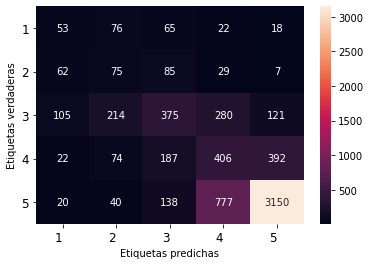

In [17]:
# se calculan los valores de error y las predicciones obtenidas
valor_error, valor_precision, valor_rmse, predicciones = validacion_metricas(modelo, carga_validacion)
print(f"Valor de error en los datos de entrenamiento: {valor_error}.") 
print(f"Presición (accuracy) en los datos de entrenamiento {valor_precision}.") 
print(f"Raíz del error cuadrático medio en los datos de entrenamiento {valor_rmse} \n")

# Función que genera una matriz de confución de n clases
#  etiquetas: lista de enteros con las etiquetas verdaderas
#  predicciones: lista de enteros con las etiquetas obtenidas del modelo
#  return: matriz con los resultados de asiertos contados por clase
def confusion_matriz(etiquetas, prediciones):
    clases = sorted(set(etiquetas))
    matriz = [[0 for _ in clases] for _ in clases]
    dic   = {valor: i for i, valor in enumerate(clases)}
    # se itera y genera la matriz de confusión
    for p, e in zip(prediciones, etiquetas):
        matriz[dic[e]][dic[e]] += 1
    return matriz

# se genera la matriz de confusión de los datos obtenidos la cual nos muestra los aciertos y 
# errores de clasificación obtenidos.
matriz_confusion = confusion_matrix(predicciones, y_prueba)
print(f"Matriz de Confusión:\n {matriz_confusion}\n")


# se genera un reporte de las metricas obtenidas mediante la función classification_report
# con los valores de precision, recall, f1-score y accuracy
etiquetas = ['1', '2', '3', '4', '5']
print(classification_report(y_prueba, predicciones, target_names=etiquetas))

# Se imprime la matriz de confusión de forma grafica con matplolib y seaborn
df_matriz_confusion = pd.DataFrame(matriz_confusion,index=etiquetas,columns=etiquetas).astype(int)
mapa_calor = sn.heatmap(df_matriz_confusion, annot=True, fmt="d")

# se grafica la matriz de confusión
mapa_calor.yaxis.set_ticklabels(mapa_calor.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=12)
mapa_calor.xaxis.set_ticklabels(mapa_calor.xaxis.get_ticklabels(), rotation=0, ha='right',fontsize=12)
plt.ylabel('Etiquetas verdaderas')
plt.xlabel('Etiquetas predichas')
plt.show()

5. Genere y documente sus conclusiones (incluya al menos cuatro conclusiones importantes).

A continuación se presentan las conclusiones obtenidas con el presente modelo de:
 - <div style='text-align: justify;'> El resultado de la precisión (accuracy) del modelo promedia el 60% a pesar de realizar distintas configuraciones, como aumentar el número de capas ocultas y visibles del modelo, aumentar el número de epocas o bien cambiar los parametros del optimizador, esto último fue lo que mayormente ayudó aumentando el porcentaje accuracy en un 10%. Además de incluir una función de Dropout para la regularización y la prevención de la coadaptación de neuronas. Este porcentaje tan bajo puede ser el resultado de utilizar un conjunto de datos tan sesgado, ya que en los datos se encontraba una gran diferencia entre las distintas calificaciones seleccionadas para el conjunto de datos, donde el total de calificaciones con puntaje de 5 (un total de 12540), supera por mucho las de los demás puntajes (1:821, 2:1549, 3:2823, 4:4908).</div>
 - <div style='text-align: justify;'> Limpiar los datos es una etapa que siempre colabora considerablemente en los distintos modelos, en este caso con un modelo de Long short-term memory, en el cual se deseaba realizar clasificación de calificaciones emitidas por personas, limpiar los datos se convierte en una actividad vital. Como primer medida implementada se nota que los comentarios se encuentran en el lenguaje inglés, se observa que una gran cantidad contienen contracciones de palabras (ejemplos: "u": "you", "'cause": "because", …) por lo que se procede a eliminar dichas contracciones que finalmente significan lo mismo, posteriormente se eliminan los caracteres especiales, con esto se disminuye el número de palabras únicas dentro del modelo. </div>
 - <div style='text-align: justify;'> Utilizar métricas como: exactitud, precisión, exhaustividad y valor f1 pueden no ser las indicadas para este problema, cuando tenemos un problema de esta clase es importante elegir que tipo de métrica es la correcta, para este modelo si nos basamos en las métricas anteriormente mencionadas y tomando en cuenta la diferencia entre los datos, el resultado parece muy erróneo. Sin embargo, en esta clase de problemas no se lo mismo clasificar mal, por ejemplo, un 5 como un 4, que un caso en que un 5 se clasifico como un 1. Asimismo, si utilizamos otras métricas como la raíz del error cuadrático medio (RMSE) donde el error es menor de 1 punto, lo cual no es malo pensando en que tampoco es una tarea fácil para nosotros como personas. </div>
 - <div style='text-align: justify;'> El modelo elaborado utiliza entradas de tamaño N para todos sus entradas, para generar vectores de tamaño fijo se agrega valores extra a los vectores de números que referencias los datos en el modelo, en nuestro caso incluimos los “pads”, que serian valores de 0 de relleno dentro de los vectores. Si bien es posible generar modelos de LSTM con vectores de tamaño variado, implementamos vectores de tamaño fijo, con esto logramos disminuir el tiempo de entrenamiento en comparación con un modelo de vectores de tamaño variable, que tampoco es que genera un avance significativo en cuanto validación por métricas. </div>

Referencias
----------------
* Agrawal, S. (2021, 9 abril). Sentiment Analysis using LSTM Step by Step Tutorial | Deep Learning | Towards Data Science. Recuperado 1 de junio de 2021, de https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948

* bentrevett. (2021, 12 abril). pytorch-sentiment-analysis. Recuperado 1 de junio de 2021, de https://github.com/bentrevett/pytorch-sentiment-analysis

* Hinton, G. E., Srivastava, N., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. R. (2012, 3 julio). Improving neural networks by preventing co-adaptation of feature detectors. Recuperado 1 de junio de 2021, de https://arxiv.org/abs/1207.0580

* N S, A. (2020, 9 julio). Multiclass Text Classification using LSTM in Pytorch. Recuperado 1 de junio de 2021, de https://towardsdatascience.com/multiclass-text-classification-using-lstm-in-pytorch-eac56baed8df

## B. Reconocimiento   de   nombres   de   entidades   (NER,   Name   EntityRecognition) con redes neuronales recurrentes utilizando Pytorch.

El reconocimiento de nombres de entidades (NER)  es  el proceso  de identificar y categorizar elementos clave (ej. entidades) en el texto. Una entidad puede ser cualquier palabra o secuencia de palabras que se refieren a una persona, animal, sitio o cosa (ej.empresa, región geográfica, objeto). Cada entidad detectada se clasifica en una categoría predeterminada. Normalmente, NER se aborda como un problema de etiquetado de secuencias. Una explicación muy detallada de porqué es importante extraer entidades de los textos se encuentra en (Monge, 2020).

Los algoritmos de extracción de entidades pueden únicamente detectar la presencia de una entidad y marcarla como tal o pueden detectar y clasificar cada entidad que encuentran.

Ejemplo: En una oración como “arbusto de 2 m. flores lila.”.  Cada palabra representa un token donde “arbusto” y “flores” son los elementos de interés a marcar. El etiquetado “token inicial- token interno” es una forma común de indicar dónde comienzan y terminan las entidades. En el ejemplo anterior la etiqueta sería “B O O O B O” donde B representael inicio de la entidad y O cualquier otro token. Para la oración “botones florales rosados.” la etiqueta estaría dada por “B I O” donde “B” marca el token inicio de la entidad e “I” los otros tokens que son parte de esta, es decir “B I” delimita la entidad “botones florales”. 

Otra forma de marcar y etiquetar, es además de delimitar la entidad, asignar a esta la clase a la que corresponde, por ejemplo: empresa, ciudad, persona, entre otros. Para el presente ejercicio se va a utilizar este enfoque.

Utilice los datos para reconocer y clasificar nombres de entidades compartidos en Kaggle por (Ranjan, 2020) para:

1. Cargue y prepare los datos para ser introducidos a la red recurrente.

In [18]:
# Se cargan los datos presentes en el archivo "NER_Dataset.csv", se indica que el único delimitador 
# utilizado son las comillas para que no hayan problemas con ningún otro caracter.
ner = pd.read_csv('./data/NER_Dataset.csv', delimiter=',')

# Información sobre el dataset.
ner.head()

,Sentence_ID,Word,POS,Tag
0,Sentence: 1,"['Thousands', 'of', 'demonstrators', 'have', '...","['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 10,"['Iranian', 'officials', 'say', 'they', 'expec...","['JJ', 'NNS', 'VBP', 'PRP', 'VBP', 'TO', 'VB',...","['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '..."
2,Sentence: 100,"['Helicopter', 'gunships', 'Saturday', 'pounde...","['NN', 'NNS', 'NNP', 'VBD', 'JJ', 'NNS', 'IN',...","['O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', '..."
3,Sentence: 1000,"['They', 'left', 'after', 'a', 'tense', 'hour-...","['PRP', 'VBD', 'IN', 'DT', 'NN', 'JJ', 'NN', '...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 10000,"['U.N.', 'relief', 'coordinator', 'Jan', 'Egel...","['NNP', 'NN', 'NN', 'NNP', 'NNP', 'VBD', 'NNP'...","['B-geo', 'O', 'O', 'B-per', 'I-per', 'O', 'B-..."


In [19]:
ner.describe()

2021-06-05 16:34:28 numexpr.utils INFO: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-06-05 16:34:28 numexpr.utils INFO: NumExpr defaulting to 8 threads.


,Sentence_ID,Word,POS,Tag
count,47959,47959,47959,47959
unique,47959,47575,47214,33318
top,Sentence: 36435,"['VOA', ""'s"", 'Mil', 'Arcega', 'reports', '.']","['NNP', 'POS', 'NNP', 'NNP', 'VBZ', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
freq,1,17,39,450


In [20]:
# Eliminamos los valores vacíos en las columnas que vamos a utilizar y 
# se remueven las comillas y las comas de los textos.
for x in ["Word", "Tag"]:
    ner = ner[ner[x].notnull()]
    ner = ner[ner[x].notnull()]
    
    ner[x] = ner[x].str.replace("'", '', regex=True)
    ner[x] = ner[x].str.replace(", ", ' ', regex=True)
    
ner.head()

,Sentence_ID,Word,POS,Tag
0,Sentence: 1,[Thousands of demonstrators have marched throu...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...",[O O O O O O B-geo O O O O O B-geo O O O O O B...
1,Sentence: 10,[Iranian officials say they expect to get acce...,"['JJ', 'NNS', 'VBP', 'PRP', 'VBP', 'TO', 'VB',...",[B-gpe O O O O O O O O O O O O O O B-tim O O O...
2,Sentence: 100,[Helicopter gunships Saturday pounded militant...,"['NN', 'NNS', 'NNP', 'VBD', 'JJ', 'NNS', 'IN',...",[O O B-tim O O O O O B-geo O O O O O B-org O O...
3,Sentence: 1000,[They left after a tense hour-long standoff wi...,"['PRP', 'VBD', 'IN', 'DT', 'NN', 'JJ', 'NN', '...",[O O O O O O O O O O O]
4,Sentence: 10000,[U.N. relief coordinator Jan Egeland said Sund...,"['NNP', 'NN', 'NN', 'NNP', 'NNP', 'VBD', 'NNP'...",[B-geo O O B-per I-per O B-tim O B-geo O B-gpe...


In [21]:
# Se define como "X" los valores en la columna "Word" y como "y" los valores en la columna "Tag",
# sin tomar en cuenta los primeros y últimos caracteres de los textos ("[", "]").
X = ner['Word']
X = [elem[1:-1].split() for elem in X]

y = ner['Tag']
y = [elem[1:-1].split() for elem in y]

# Se crea un diccionario con todas las palabras presentes en los textos.
indice_palabras = {}
for frase in X:
    for palabra in frase:
        if palabra not in indice_palabras:
            indice_palabras[palabra] = len(indice_palabras)

# Se crea un diccionario con todas las etiquetas presentes en el dataset.          
indice_etiquetas = {'O':0,'B-geo':1,'B-gpe':2,'B-org':3,'B-nat':4,'B-art':5,'B-eve':6,'B-tim':7,'B-per':8,
                      'I-geo':9,'I-gpe':10,'I-org':11,'I-nat':12,'I-art':13,'I-eve':14,'I-tim':15,'I-per':16}

2. Utilizando PyTorch defina una red recurrente LSTM para procesar, localizar y clasificar las entidades presentes en el texto (como la vista en clase). 

In [22]:
# Definición del modelo

# El modelo es una clase LSTM (Long Sort-Term Memory) que debe heredar de nn.Module
# y en el que se usamos "embeddings" para las palabras.
class LSTMTagger(nn.Module):
    
    # Inicialización del modelo, se debe recibir la dimensionalidad de salida del "embedding", 
    # la cantidad de dimensiones ocultas, la cantidad de palabras diferentes y la cantidad de etiquetas.
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        # Primero se pasa la entrada a través de una capa Embedding. 
        # Esta capa construye una representación de los tokens de 
        # un texto donde las palabras que tienen el mismo significado 
        # tienen una representación similar. En Pytorch, se usa el 
        # módulo nn.Embedding para crear esta capa
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # El LSTM toma word_embeddings como entrada y genera estados ocultos
        # con dimensionalidad hidden_dim.  
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # La capa lineal mapea el espacio de estado oculto 
        # al espacio de etiquetas
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        # Pase hacia adelante de la red. Se recibe la oración a procesar.
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        
        # Se utiliza softmax para devolver un peso por etiqueta.
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

# Instanciación del modelo, definición de la función de pérdida y del optimizador   

# Hiperparámetros de la red
# Valores generalmente altos (32 o 64 dimensiones).
# Se definen pequeños, para ver cómo cambian los pesos durante el entrenamiento.

EMBEDDING_DIM = 32
HIDDEN_DIM = 32
cantidad_palabras = len(indice_palabras)
cantidad_etiquetas = len(indice_etiquetas)

# Instancia del modelo
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, cantidad_palabras, cantidad_etiquetas)

# Función de pérdida: Negative Log Likelihood Loss (NLLL). 
# Útil para problemas de clasificacion con C clases.
loss_function = nn.NLLLoss()

# Optimizador: Stochastic Gradient Descent  
optimizer = optim.SGD(model.parameters(), lr=0.1)

3. Separe las muestras en datos de entrenamiento y evaluación y entrene el modelo. 

In [23]:
# Se barajan los datos según una proporción predefinida.
proporcion = lambda : 0.7

random.shuffle(X, proporcion)
random.shuffle(y, proporcion)

# Se dividen los datos por un índice.
indice = int(len(X)*0.3)

X_train, y_train = X[indice:], y[indice:]
X_test, y_test = X[:indice], y[:indice]

# Se imprimen los primeros 3 elementos de los 
# datos de entrenamiento.
print("X_train:", *X_train[:3], sep = "\n")
print("\ny_train:", *y_train[:3], sep = "\n")

X_train:
['In', 'western', 'Baghdad', ',', 'a', 'roadside', 'bomb', 'killed', 'an', 'Iraqi', 'policeman', 'and', 'wounded', 'two', 'others', '.']
['The', 'U.S.', 'military', 'said', 'an', 'American', 'soldier', 'died', 'when', 'a', 'roadside', 'bomb', 'hit', 'his', 'convoy', 'southwest', 'of', 'Baghdad', '.']
['The', 'U.N.', 'Food', 'and', 'Agricultural', 'Organization', 'has', 'warned', 'that', 'the', 'bird', 'flu', 'that', 'has', 'hit', 'Turkey', 'may', 'already', 'have', 'arrived', 'in', 'neighboring', 'countries', '.']

y_train:
['O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B-geo', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O']
['O', 'B-org', 'I-org', 'I-org', 'I-org', 'I-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Número de época: 0
Pérdida: 1.3943302631378174
Número de época: 1
Pérdida: 1.1781061887741089
Número de época: 2
Pérdida: 0.9704211950302124
Número de época: 3
Pérdida: 0.8530060052871704
Número de época: 4
Pérdida: 0.763014018535614
Número de época: 5
Pérdida: 0.676301121711731
Número de época: 6
Pérdida: 0.6049211621284485
Número de época: 7
Pérdida: 0.5455679297447205
Número de época: 8
Pérdida: 0.5002492666244507
Número de época: 9
Pérdida: 0.4630630910396576
Número de época: 10
Pérdida: 0.4373316764831543
Número de época: 11
Pérdida: 0.4120200276374817
Número de época: 12
Pérdida: 0.38432446122169495
Número de época: 13
Pérdida: 0.3660498857498169
Número de época: 14
Pérdida: 0.34832435846328735
Número de época: 15
Pérdida: 0.34832435846328735


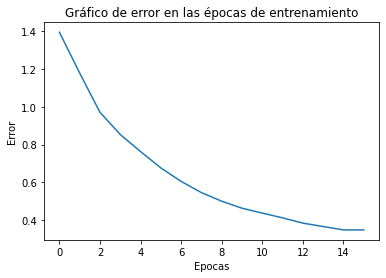

In [24]:
# Preparación de los datos 
def preparar_secuencia(secuencia, indice_secuencias):
    # Prepara tensores de indices de palabras a partir de una oración. 
    # Se recibe una secuencia en una lista y su diccionario correspondiente.
    idxs = [indice_secuencias[elem] for elem in secuencia]
    return torch.tensor(idxs, dtype=torch.long)

# Entrenar el modelo

num_epocas = 15

lista_error = []
loss = math.inf

# Épocas de entrenamiento
for epoca in range(num_epocas):  
    
    for sentence, etiqueta in zip(X_train, y_train):
        
        ## Paso 1. Pytorch acumula los gradientes.
        # Es necesario limpiarlos
        model.zero_grad()

        # Paso 2. Se preparan las entradas, es decir, se convierten a
        # tensores de índices de palabras.
        sentence_in = preparar_secuencia(sentence, indice_palabras)
        targets = preparar_secuencia(etiqueta, indice_etiquetas)
        
        # Paso 3. Se genera la predicción (forward pass).
        tag_scores = model(sentence_in)

        # Paso 4. se calcula la pérdida, los gradientes, y se actualizan los 
        # parámetros por medio del optimizador.
        loss = loss_function(tag_scores, targets)
        
        loss.backward()
        optimizer.step()
    
    lista_error.append(loss)
    print(f"Número de época: {epoca}")
    print(f"Pérdida: {loss}")

lista_error.append(loss)
print(f"Número de época: {num_epocas}")
print(f"Pérdida: {loss}")

plt.figure()
plt.plot(lista_error)
plt.xlabel('Epocas')
plt.ylabel('Error')
plt.title('Gráfico de error en las épocas de entrenamiento')
plt.show()

4. Evalúe el modelo resultante. Utilice la métrica propuesta por el InternationalWorkshop on Semantic Evaluation (SemEval), una explicación básica está disponible en (Batista, 2018).  

In [25]:
# Performance per label type per token

# Funciones utilitarias

# Retorna el índice del valor máximo en un vector x.
def inds_max(x):
    
    out, inds = torch.max(x,dim=1)   
    return inds

# Retorna la predicción del modelo ante ciertos datos
def obtener_pred(datos):
    
    with torch.no_grad():
        inputs = preparar_secuencia(datos, indice_palabras)
        valores_de_etiquetas = model(inputs)
        pred = inds_max(valores_de_etiquetas)
        
    return pred.tolist()

# Se obtienen los valores de las etiquetas junto con sus predicciones.
y_pred = []
y_test_procesada = []

for i in range(len(X_test)):
    y_test_procesada.append(preparar_secuencia(y_test[i], indice_etiquetas).tolist())
    y_pred.append(obtener_pred(X_test[i]))

# Se obtienen las etiquetas como fueron usadas en el modelo.
etiquetas_modelo = [k for k, v in indice_etiquetas.items()]
etiquetas_procesadas = deepcopy(etiquetas_modelo[1:])
print("Etiquetas procesadas:\n", etiquetas_procesadas)

# Se obtienen las predicciones según la lista de etiquetas.
pred_labels = []

for i in range(len(y_pred)):
    temp = []
    for elem in y_pred[i]:
        temp.append(etiquetas_modelo[elem])
    pred_labels.append(temp[:])

print("Métrica del rendimiento por tipo de etiqueta por token:")
print(sklearn_crfsuite.metrics.flat_classification_report(y_test, pred_labels, labels=etiquetas_procesadas, digits=3, zero_division=0))

Etiquetas procesadas:
 ['B-geo', 'B-gpe', 'B-org', 'B-nat', 'B-art', 'B-eve', 'B-tim', 'B-per', 'I-geo', 'I-gpe', 'I-org', 'I-nat', 'I-art', 'I-eve', 'I-tim', 'I-per']
Métrica del rendimiento por tipo de etiqueta por token:


/home/walter/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-geo', 'B-gpe', 'B-org', 'B-nat', 'B-art', 'B-eve', 'B-tim', 'B-per', 'I-geo', 'I-gpe', 'I-org', 'I-nat', 'I-art', 'I-eve', 'I-tim', 'I-per'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


              precision    recall  f1-score   support

       B-geo      0.795     0.829     0.811     11144
       B-gpe      0.913     0.911     0.912      4804
       B-org      0.678     0.534     0.597      6163
       B-nat      0.667     0.113     0.194        53
       B-art      0.000     0.000     0.000       108
       B-eve      0.810     0.181     0.296        94
       B-tim      0.895     0.784     0.836      6135
       B-per      0.727     0.698     0.712      4965
       I-geo      0.753     0.724     0.738      2128
       I-gpe      1.000     0.346     0.514        52
       I-org      0.742     0.661     0.699      5101
       I-nat      0.000     0.000     0.000        18
       I-art      0.000     0.000     0.000        74
       I-eve      0.667     0.023     0.044        87
       I-tim      0.705     0.678     0.691      1995
       I-per      0.847     0.748     0.794      5123

   micro avg      0.794     0.735     0.763     48044
   macro avg      0.637   

In [26]:
# Performance over full named-entity

# Se utilizan las funciones presentes en la biblioteca ner_evaluation.

# Se comprueban los resultados con el elemento en índice 0
index = 0
true = collect_named_entities(y_test[index])
pred = collect_named_entities(pred_labels[index])

print("Valores verdaderos:\n", true)

print("Valores predi:\n", pred)

Valores verdaderos:
 [Entity(e_type='geo', start_offset=6, end_offset=6), Entity(e_type='geo', start_offset=12, end_offset=12), Entity(e_type='gpe', start_offset=18, end_offset=18)]
Valores predi:
 [Entity(e_type='geo', start_offset=6, end_offset=6), Entity(e_type='geo', start_offset=12, end_offset=12), Entity(e_type='gpe', start_offset=18, end_offset=18)]


In [27]:
print("Métricas de este valor con las etiquetas \"geo\", \"gpa\":")
compute_metrics(true, pred, ['geo', 'gpe'])

Métricas de este valor con las etiquetas "geo", "gpa":


({'strict': {'correct': 3,
   'incorrect': 0,
   'partial': 0,
   'missed': 0,
   'spurious': 0,
   'precision': 0,
   'recall': 0,
   'actual': 3,
   'possible': 3},
  'ent_type': {'correct': 3,
   'incorrect': 0,
   'partial': 0,
   'missed': 0,
   'spurious': 0,
   'precision': 0,
   'recall': 0,
   'actual': 3,
   'possible': 3},
  'partial': {'correct': 3,
   'incorrect': 0,
   'partial': 0,
   'missed': 0,
   'spurious': 0,
   'precision': 0,
   'recall': 0,
   'actual': 3,
   'possible': 3},
  'exact': {'correct': 3,
   'incorrect': 0,
   'partial': 0,
   'missed': 0,
   'spurious': 0,
   'precision': 0,
   'recall': 0,
   'actual': 3,
   'possible': 3}},
 {'geo': {'strict': {'correct': 2,
    'incorrect': 0,
    'partial': 0,
    'missed': 0,
    'spurious': 0,
    'precision': 0,
    'recall': 0,
    'actual': 2,
    'possible': 2},
   'ent_type': {'correct': 2,
    'incorrect': 0,
    'partial': 0,
    'missed': 0,
    'spurious': 0,
    'precision': 0,
    'recall': 0,
    '

In [28]:
# Results over all messages

# Para evaluar el modelo.
metrics_results = {'correct': 0, 'incorrect': 0, 'partial': 0,
                   'missed': 0, 'spurious': 0, 'possible': 0, 'actual': 0, 'precision': 0, 'recall': 0}

'''
Significado de las no conocidas, al comparar las etiquetas predichas con las originales del texto:

Correct (COR) 	 Las dos son iguales
Incorrect (INC) 	 La salida del sistema y las etiquetas originales no coinciden
Partial (PAR) 	 La salida del sistema y las etiquetas originales son de alguna manera "similares" 
                 pero no las mismas
Missing (MIS) 	 Una etiqueta original no es capturada por el sistema
Spurius (SPU) 	 El programa produce una etiqueta que no existe en las etiquetas originales
'''

# Métricas donde serán almacenados los resultados.
results = {'strict': deepcopy(metrics_results),
           'ent_type': deepcopy(metrics_results),
           'partial':deepcopy(metrics_results),
           'exact':deepcopy(metrics_results)
          }

'''
Significado de las métricas:

Strict  	 Coincidencia exacta entre la cadena de texto y el tipo de entidad
Exact 	 Coincidencia exacta entre la cadena de texto, sin importar el tipo
Partial 	 Coincidencia parcial entre la cadena de texto, sin importar el tipo
Type 	 Se requiere cierta superposición entre la entidad etiquetada por el sistema y la etiquetación predicha
'''

labels_test = ['nat', 'geo', 'tim', 'eve', 'per', 'org', 'art', 'gpe']

# Resultados agregados por tipo de entidad.
evaluation_agg_entities_type = {e: deepcopy(results) for e in labels_test}

for true_ents, pred_ents in zip(y_test, pred_labels):
    
    # Calcular resultados para un valor.
    tmp_results, tmp_agg_results = compute_metrics(
        collect_named_entities(true_ents), collect_named_entities(pred_ents),  labels_test
    )

    # Resultados globales agregados.
    for eval_schema in results.keys():
        for metric in metrics_results.keys():
            results[eval_schema][metric] += tmp_results[eval_schema][metric]
            
    # Cálculo de la precisión global y el recall.
    results = compute_precision_recall_wrapper(results)

    # Resultados agregados por tipo de entidad.
    for e_type in labels_test:

        for eval_schema in tmp_agg_results[e_type]:

            for metric in tmp_agg_results[e_type][eval_schema]:
                
                evaluation_agg_entities_type[e_type][eval_schema][metric] += tmp_agg_results[e_type][eval_schema][metric]
                
        # Cálculo de la precisión y el recall a nivel individual de la entidad
        evaluation_agg_entities_type[e_type] = compute_precision_recall_wrapper(evaluation_agg_entities_type[e_type])

print("Resultados de la métrica:")
results

Resultados de la métrica:


{'ent_type': {'correct': 25061,
  'incorrect': 2557,
  'partial': 0,
  'missed': 5885,
  'spurious': 6593,
  'possible': 33503,
  'actual': 34211,
  'precision': 0.732542164800795,
  'recall': 0.74802256514342},
 'partial': {'correct': 26278,
  'incorrect': 0,
  'partial': 1340,
  'missed': 5885,
  'spurious': 6593,
  'possible': 33503,
  'actual': 34211,
  'precision': 0.7876998626172869,
  'recall': 0.80434587947348},
 'strict': {'correct': 23920,
  'incorrect': 3698,
  'partial': 0,
  'missed': 5885,
  'spurious': 6593,
  'possible': 33503,
  'actual': 34211,
  'precision': 0.6991903189032768,
  'recall': 0.7139659135002836},
 'exact': {'correct': 26278,
  'incorrect': 1340,
  'partial': 0,
  'missed': 5885,
  'spurious': 6593,
  'possible': 33503,
  'actual': 34211,
  'precision': 0.7681155184005145,
  'recall': 0.7843476703578784}}

In [29]:
print("Resultados agregados por tipo de entidad de la métrica:")
evaluation_agg_entities_type

Resultados agregados por tipo de entidad de la métrica:


{'nat': {'ent_type': {'correct': 6,
   'incorrect': 11,
   'partial': 0,
   'missed': 36,
   'spurious': 6593,
   'possible': 53,
   'actual': 6610,
   'precision': 0.000907715582450832,
   'recall': 0.11320754716981132},
  'partial': {'correct': 17,
   'incorrect': 0,
   'partial': 0,
   'missed': 36,
   'spurious': 6593,
   'possible': 53,
   'actual': 6610,
   'precision': 0.002571860816944024,
   'recall': 0.32075471698113206},
  'strict': {'correct': 6,
   'incorrect': 11,
   'partial': 0,
   'missed': 36,
   'spurious': 6593,
   'possible': 53,
   'actual': 6610,
   'precision': 0.000907715582450832,
   'recall': 0.11320754716981132},
  'exact': {'correct': 17,
   'incorrect': 0,
   'partial': 0,
   'missed': 36,
   'spurious': 6593,
   'possible': 53,
   'actual': 6610,
   'precision': 0.002571860816944024,
   'recall': 0.32075471698113206}},
 'geo': {'ent_type': {'correct': 9116,
   'incorrect': 772,
   'partial': 0,
   'missed': 1257,
   'spurious': 6593,
   'possible': 11145,

In [30]:
# Se hace uso de las bibliotecas brindadas para realizar los cálculos anteriores.

evaluator = Evaluator(y_test, pred_labels, labels_test)
results, results_agg = evaluator.evaluate()

print("Resultados de la métrica:")
results

2021-06-05 17:34:20 root INFO: Imported 14387 predictions for 14387 true examples


Resultados de la métrica:


{'ent_type': {'correct': 25061,
  'incorrect': 2557,
  'partial': 0,
  'missed': 5885,
  'spurious': 6593,
  'possible': 33503,
  'actual': 34211,
  'precision': 0.732542164800795,
  'recall': 0.74802256514342},
 'partial': {'correct': 26278,
  'incorrect': 0,
  'partial': 1340,
  'missed': 5885,
  'spurious': 6593,
  'possible': 33503,
  'actual': 34211,
  'precision': 0.7876998626172869,
  'recall': 0.80434587947348},
 'strict': {'correct': 23920,
  'incorrect': 3698,
  'partial': 0,
  'missed': 5885,
  'spurious': 6593,
  'possible': 33503,
  'actual': 34211,
  'precision': 0.6991903189032768,
  'recall': 0.7139659135002836},
 'exact': {'correct': 26278,
  'incorrect': 1340,
  'partial': 0,
  'missed': 5885,
  'spurious': 6593,
  'possible': 33503,
  'actual': 34211,
  'precision': 0.7681155184005145,
  'recall': 0.7843476703578784}}

In [31]:
print("Resultados agregados por tipo de entidad de la métrica:")

results_agg

Resultados agregados por tipo de entidad de la métrica:


{'nat': {'ent_type': {'correct': 6,
   'incorrect': 11,
   'partial': 0,
   'missed': 36,
   'spurious': 6593,
   'possible': 53,
   'actual': 6610,
   'precision': 0.000907715582450832,
   'recall': 0.11320754716981132},
  'partial': {'correct': 17,
   'incorrect': 0,
   'partial': 0,
   'missed': 36,
   'spurious': 6593,
   'possible': 53,
   'actual': 6610,
   'precision': 0.002571860816944024,
   'recall': 0.32075471698113206},
  'strict': {'correct': 6,
   'incorrect': 11,
   'partial': 0,
   'missed': 36,
   'spurious': 6593,
   'possible': 53,
   'actual': 6610,
   'precision': 0.000907715582450832,
   'recall': 0.11320754716981132},
  'exact': {'correct': 17,
   'incorrect': 0,
   'partial': 0,
   'missed': 36,
   'spurious': 6593,
   'possible': 53,
   'actual': 6610,
   'precision': 0.002571860816944024,
   'recall': 0.32075471698113206}},
 'geo': {'ent_type': {'correct': 9116,
   'incorrect': 772,
   'partial': 0,
   'missed': 1257,
   'spurious': 6593,
   'possible': 11145,

5. Genere   y   documente   sus   conclusiones   (incluya   al   menos   cuatro conclusiones importantes).

A continuación se presentan las conclusiones obtenidas de este ejercicio:

- <div style='text-align: justify;'> Fue necesario el preprocesamiento de los textos que entraron en el modelo; una vez fueron recuperados del archivo que los contenía, se removieron las comillas, los paréntesis cuadrados y las comas que no eran parte del texto (esto último fue especialmente necesario puesto que estos símbolos eran marcados por etiquetas a tomar en cuenta). Además, se aplicó el uso de embeddings con el fin de representar mejor las relaciones entre palabras y hacer los datos de entrada más entendibles para el modelo, esto ayudó en sobremanera al rendimiento del sistema.</div>

- <div style='text-align: justify;'> Nuestro modelo presenta resultados muy buenos en cada una de las métricas definidas por la SemEval para la evaluación de modelos Named Entity Recognition (NER). En cada una de las agrupaciones se puede observar una gran cantidad de resultados correctos en comparación con la cantidad de incorrectos. Además, consideramos que todavía se podría dar un aumento en el rendimiento del programa al incrementar la cantidad de épocas de entrenamiento y en la cantidad de dimensiones en las capas del modelo (lo que traería un gran aumento en el tiempo necesario para usar el modedo en nuestro hardware actual).</div>

- <div style='text-align: justify;'> El uso de la evaluación semántica (SemEval) propuesta por la InternationalWorkshop nos permite comparar nuestros resultados de una manera estandarizada y entendible. Gracias a esta, pudimos comprobar que nuestros resultados están en lo que cabría esperar de un modelo que se encarga de realizar un trabajo tan complejo, como lo sería la comprensión del significado del lenguaje (mediante el análisis semántico).</div>

- <div style='text-align: justify;'> En este trabajo se evidenció el gran impacto que tiene la cantidad de dimensiones en las capas que son definidas en el modelo. Se comenzó a trabajar con una cantidad pequeña, lo que resultó en un modelo que se entrenaba rápidamente pero que no mostraba resultados tan sobresalientes en las métricas utilizadas. Más adelante y finalmente, se decidió aumentar el número de estas dimensiones, lo que resultó en un aumento considerable en desde la primera etapa de entrenamiento en el rendimiento del sistema, sin embargo, esto también trajo un aumento considerable en el tiempo necesario para finalizar los entrenamientos (como era de esperar).</div> 

Referencias
----------------
* Batista, D. (2018, 9 mayo). Named-Entity evaluation metrics based on entity-level. davidsbatista.net. Recuperado de http://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/

* Guthrie, R. (2017). Tutorial. Sequence Models and Long-Short Term Memory Networks. Recuperado de https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

* ivyleavedtoadflax. (s. f.). Nervaluate. GitHub. Recuperado de https://github.com/ivyleavedtoadflax/nervaluate

* Loye, G. (2019, 16 agosto). Long Short-Term Memory: From Zero to Hero with PyTorch. FloydHub Blog. Recuperado de https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/

* LSTM — PyTorch 1.8.1 documentation. (s. f.). Pytorch.Org. Recuperado de https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

* Nakov, P. (2016, 20 enero). Developing a successful SemEval task in sentiment analysis of Twitter and other social media texts. Language Resources and Evaluation. Recuperado de https://link.springer.com/article/10.1007/s10579-015-9328-1?error=cookies_not_supported&code=697cc355-80e0-4625-ab34-e03c70b4aaef

* Wikipedia contributors. (s. f.). SemEval. Wikipedia. Recuperado de https://en.wikipedia.org/wiki/SemEval